# Showcase of regime extraction process

We use the _SnippetFinder_ algorithm to detect snippets of period length `m` in a time series.
The algorithm automatically computes each snippet's profile, and the global area under the profiles.
Using these data structures we can extract regimes from the time series (one for each snippet).
These regimes are then used to generate training time series with different base behavior.

In this notebook, we show the regime extraction data structures for an example dataset.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import stumpy

from matplotlib.legend_handler import HandlerNpoints
from matplotlib.lines import Line2D
from nx_config.test_utils import update_section
from sklearn.preprocessing import MinMaxScaler

from common import PROJECT_ROOT
from autotsad.config import config
from autotsad.dataset import TestDataset

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

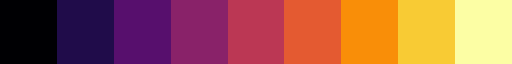

In [2]:
cm = matplotlib.colormaps["inferno"].resampled(9)
cm

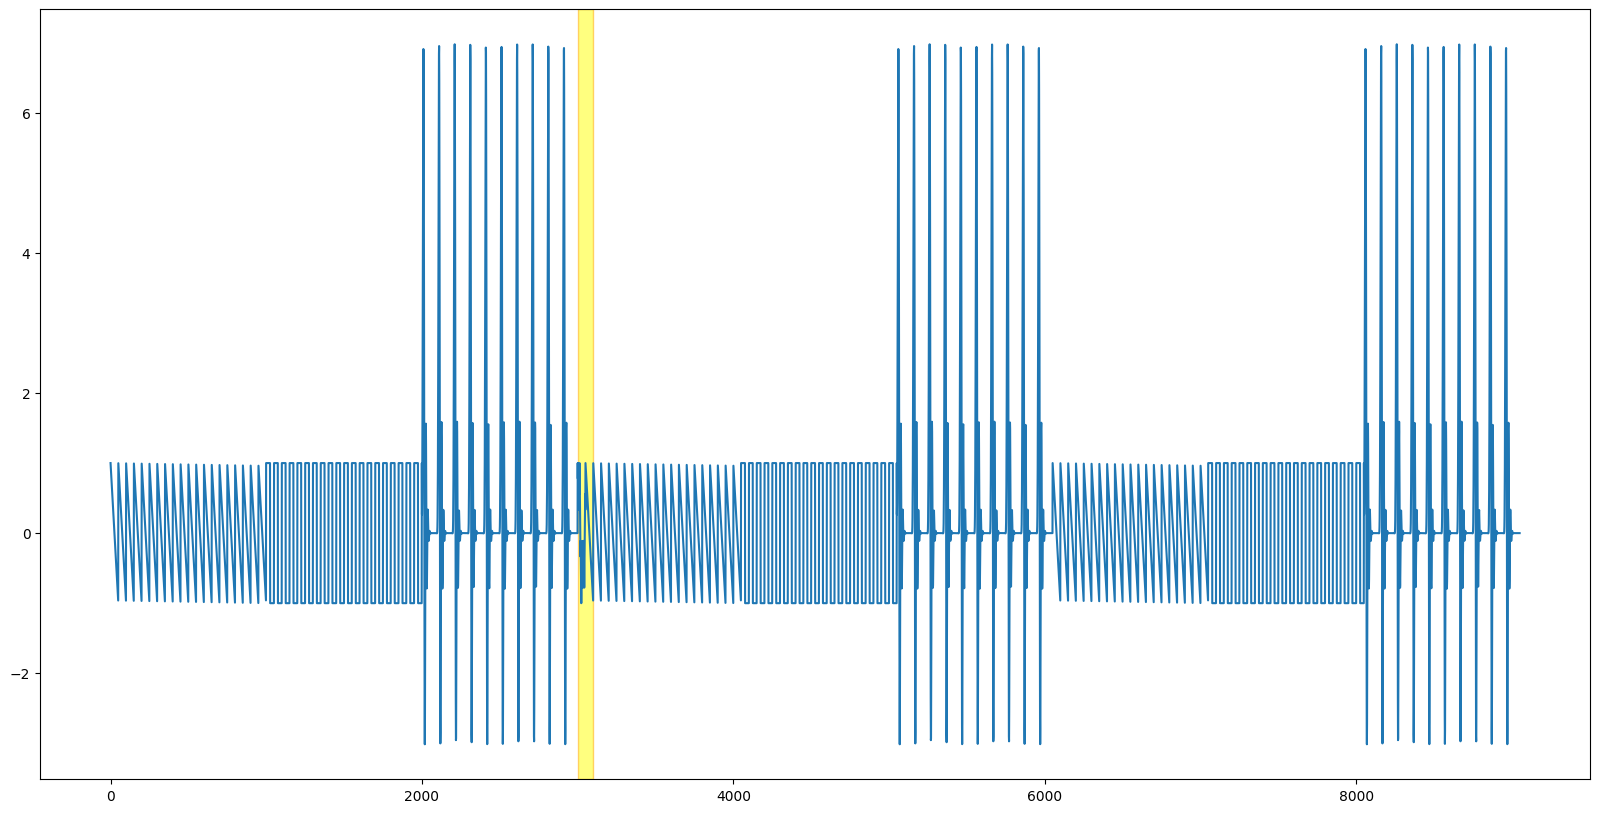

In [3]:
# Load data
testdataset = TestDataset.from_file(PROJECT_ROOT / "data" / "synthetic" / "gt-2.csv")
testdataset.plot()

In [4]:
# adjust default config
update_section(
    config.general,
    cache_key=testdataset.hexhash,
    progress=False,
    n_jobs=1,
    use_timer=False,
)
update_section(
    config.data_gen,
    snippets_max_no=5,
)
update_section(
    config.data_gen_plotting,
    profile_area=True,
    snippets=True,
    snippet_regimes=True,
    snippet_profiles=True,
    regime_overlap_pruning=True,
)

# and then import modules
from autotsad.dataset import TrainingDatasetCollection
from autotsad.system.data_gen.regiming import find_best_k, extract_regimes

In [5]:
# execute individual parts of the regime extraction process
collection = TrainingDatasetCollection(test_data=testdataset)
period_size = 100
general_config = config.general
data_gen_config = config.data_gen
data_gen_plot_config = config.data_gen_plotting

print("Running SnippetFinder")
_snippets, indices, profiles, _fractions, areas, _regimes = stumpy.snippets(
    T=collection.test_data.data,
    m=period_size,
    k=data_gen_config.snippets_max_no,
    percentage=data_gen_config.SNIPPETS_DIST_WINDOW_SIZE_PERCENTAGE
)
best_k = find_best_k(areas, period=period_size, data_gen_config=data_gen_config, plot_profile_area=False)
print(f"Best k={best_k}")

# extract snippet regimes but use only the best k snippets
p_idx = np.arange(profiles.shape[0])[:best_k]
regimes, p_idx = extract_regimes(profiles, p_idx, period_size, data_gen_config=data_gen_config)

if best_k != p_idx.shape[0]:
    print(f"Number of snippets changed from {best_k} to {p_idx.shape[0]}!")

# create base time series
masks = np.zeros((best_k, collection.test_data.length), dtype=np.bool_)
for i, snippet_idx in enumerate(p_idx):
    slices_of_indices = regimes[np.where(regimes[:, 0] == snippet_idx)][:, 1:]
    for start_idx, stop_idx in slices_of_indices:
        masks[i, start_idx:stop_idx] = True


Running SnippetFinder


Regimes are too short for snippet #0: 0.0 < 5, rerunning regiming w/o it!


Best k=4
Number of snippets changed from 4 to 3!


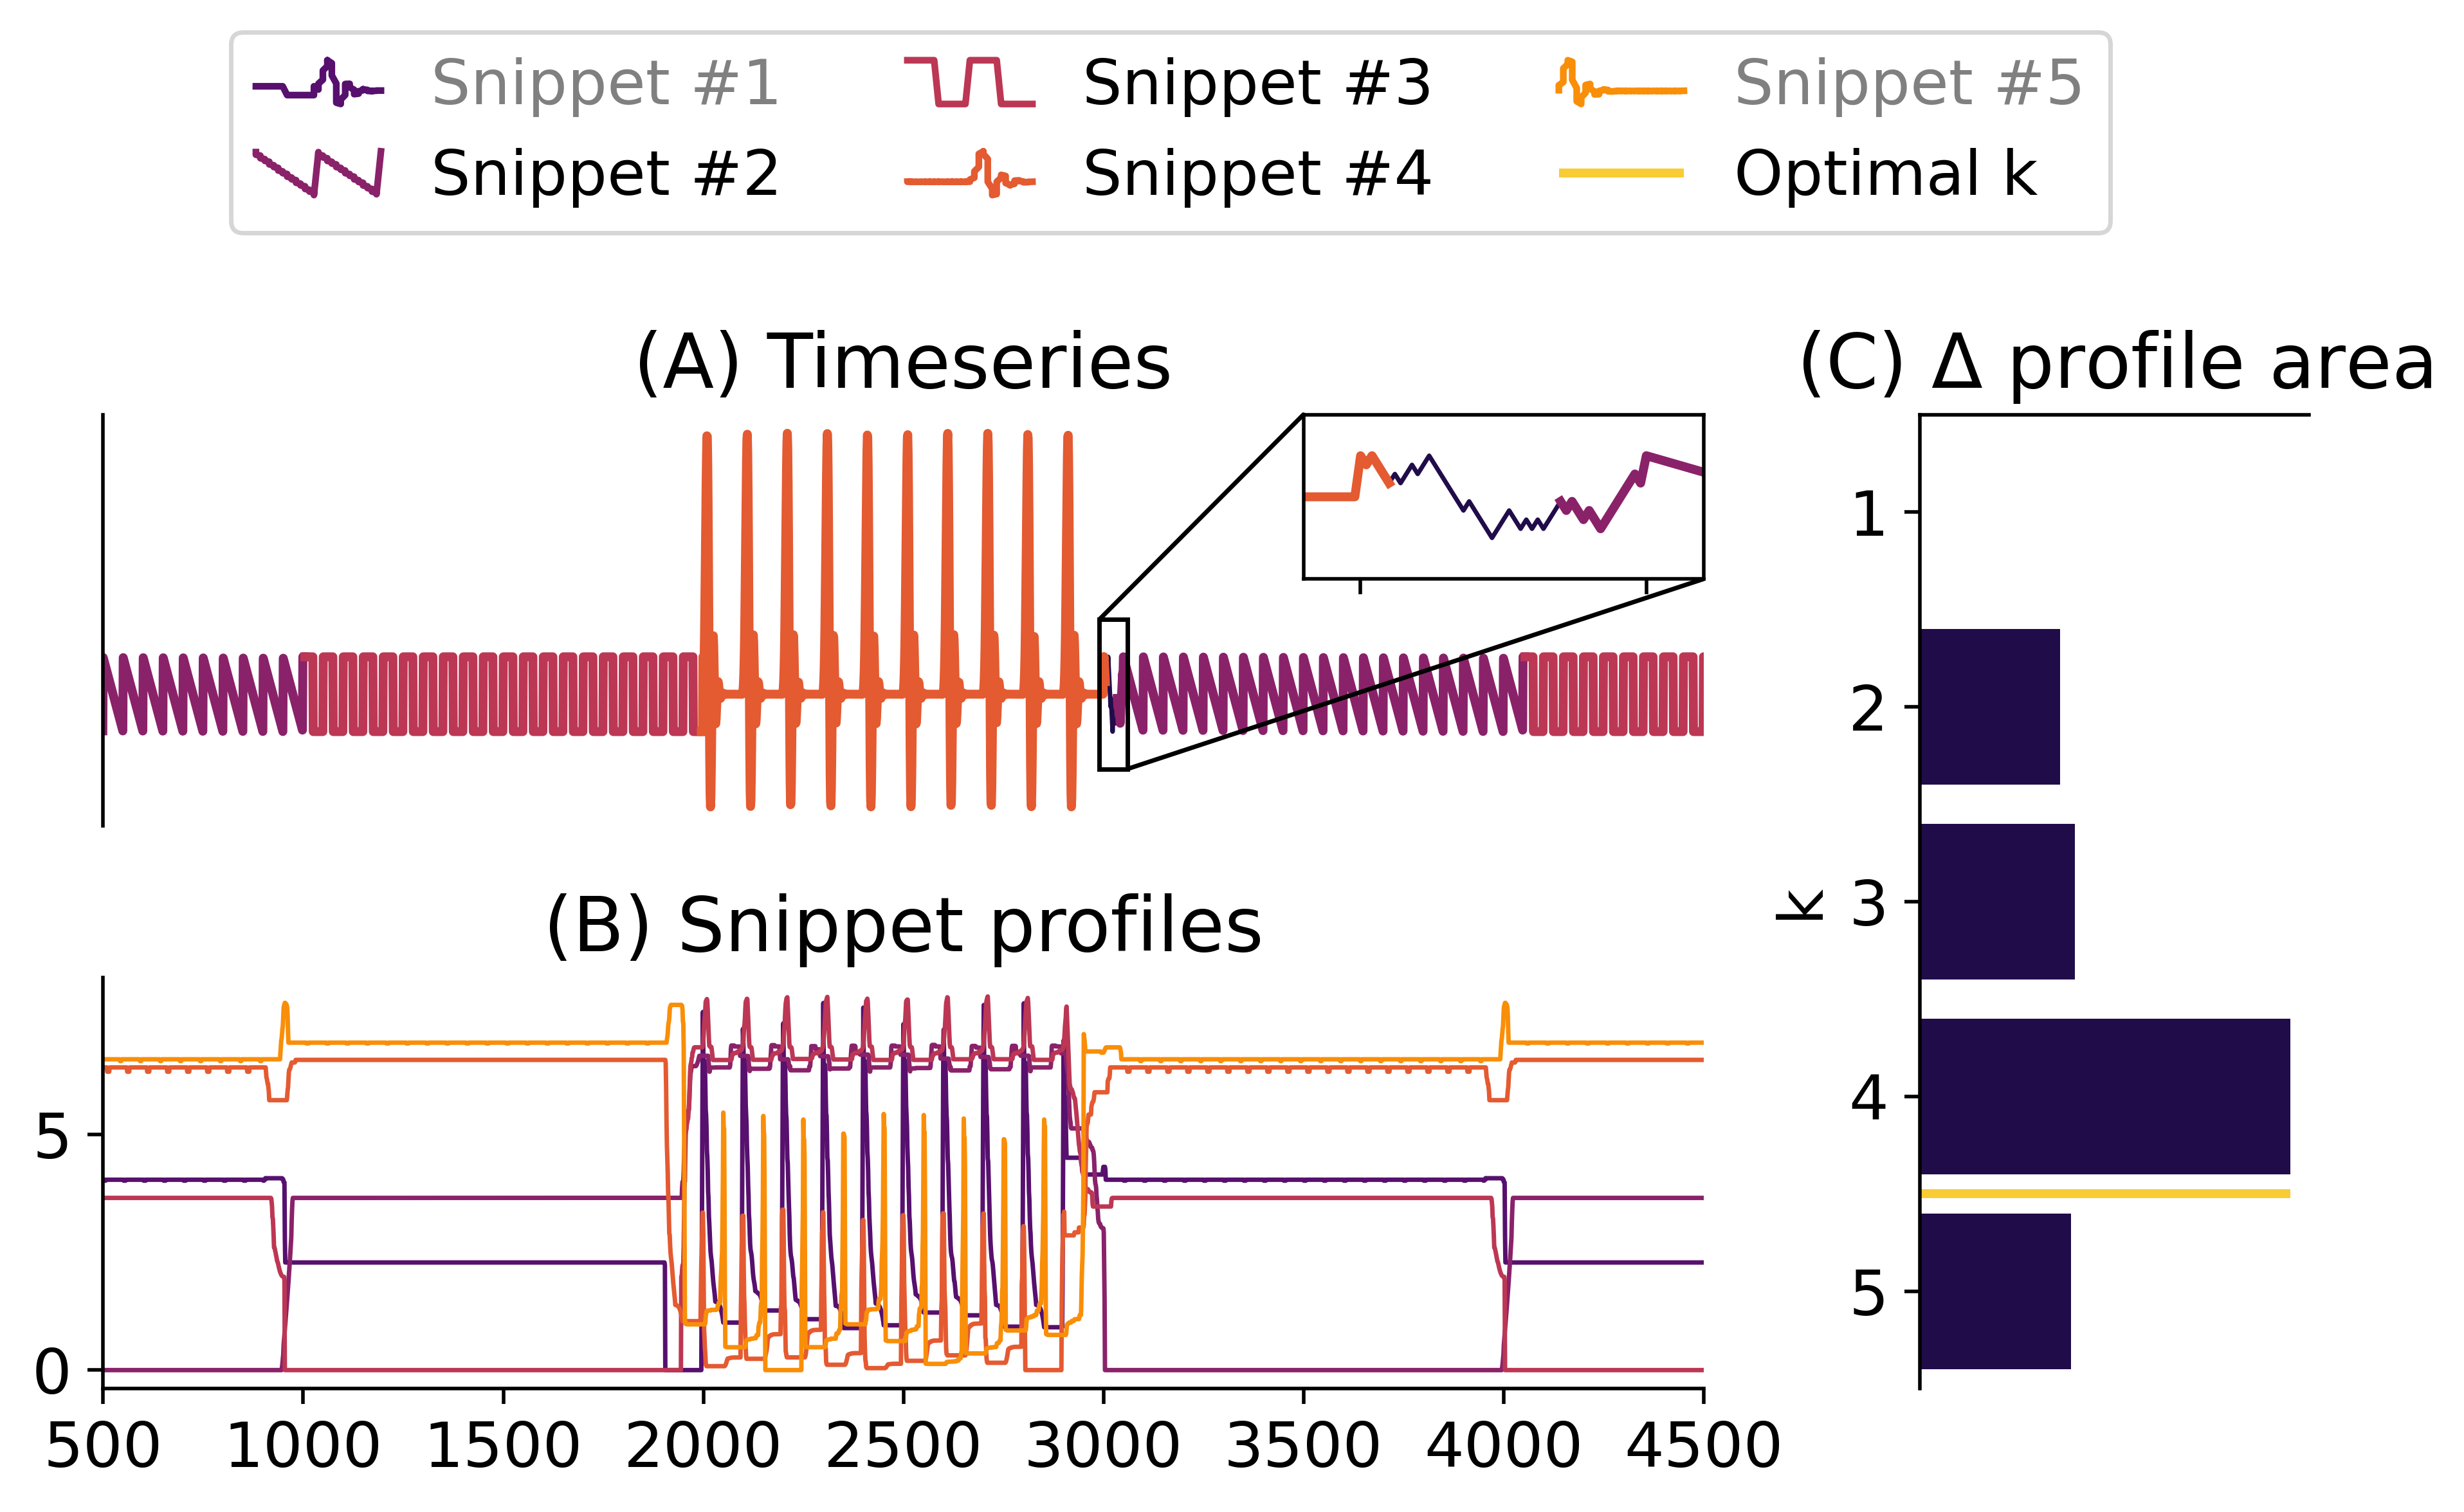

In [6]:
plt.rcParams["font.size"] = 14


use_strike_instead_of_color = False
u_strike = "\u0336"
# ts_color = (0.1, 0.1, .5)
# ts_color = "grey"
# colors = ["orange", "purple", "brown", "green", "cyan"]
# area_color = "blue"
# threshold_color = "red"

# colors = sns.cubehelix_palette(start=.25, rot=-.25, light=0.8, dark=0.2, n_colors=6)
# ts_color = colors[0]
# colors = colors[1:]
# ch_colors = sns.cubehelix_palette()
# area_color = ch_colors[1]
# threshold_color = ch_colors[3]

colors = cm.colors[2:-2]
ts_color = cm.colors[1]
area_color = cm.colors[1]
threshold_color = cm.colors[-2]

fig = plt.figure(figsize=(7.5, 4), dpi=500)
grid_shape = (2, 4)
ax0 = plt.subplot2grid(grid_shape, (0, 0), rowspan=1, colspan=3)
# ax1 = plt.subplot2grid(grid_shape, (2, 0), rowspan=2, colspan=3, sharex=ax0)
ax2 = plt.subplot2grid(grid_shape, (1, 0), rowspan=1, colspan=3, sharex=ax0)
ax3 = plt.subplot2grid(grid_shape, (0, 3), rowspan=2, colspan=1)

# plot time series
ax0.plot(collection.test_data.data, label="Timeseries", color=ts_color, lw=1)
ax0_inset0 = ax0.inset_axes([0.75, 0.6, 0.25, 0.4])
ax0_inset0.plot(collection.test_data.data, color=ts_color, lw=1)

# plot regimes
ax0.set_title("(A) Timeseries")
# ax0.set_ylabel("Regimes")
y = collection.test_data.data
for snippet_idx in p_idx:
    slices_of_indices = regimes[np.where(regimes[:, 0] == snippet_idx)][:, 1:]
    xx = np.full_like(y, fill_value=np.nan)
    for per_slice in slices_of_indices:
        start_idx = per_slice[0]
        stop_idx = per_slice[1]
        xx[start_idx:stop_idx] = y[start_idx:stop_idx]
    ax0.plot(xx, color=colors[snippet_idx], lw=2)
    ax0_inset0.plot(xx, color=colors[snippet_idx], lw=2)

ax0.set_xlim(500, 4500)
ax0.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)
ax0.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False, labeltop=False)
spines = ax0.spines
spines["top"].set_visible(False)
spines["bottom"].set_visible(False)
spines["right"].set_visible(False)

# plot uncovered region
ax0_inset0.set_xlim(2990, 3060)
ax0_inset0.set_ylim(-2, 2)
ax0_inset0.tick_params(axis="y", which="both", left=False, right=False, labelleft=False, labelright=False)
ax0_inset0.tick_params(axis="x", which="both", bottom=True, top=False, labelbottom=False, labeltop=False)
ax0.indicate_inset_zoom(ax0_inset0, edgecolor="black", alpha=1)

# plot snippet profiles
ax2.set_title("(B) Snippet profiles")
for i in np.arange(config.data_gen.snippets_max_no):
    ax2.plot(profiles[i], color=colors[i], lw=1)
spines = ax2.spines
spines["top"].set_visible(False)
spines["right"].set_visible(False)

# plot areas
ax3.set_title("(C) $\Delta$ profile area")
ax3.set_ylabel("k")
k_range = np.arange(1, data_gen_config.snippets_max_no + 1)
df_aud = pd.DataFrame({
    "area": areas,
    "area_change": np.r_[np.nan, areas[:-1] / areas[1:] - 1.0],
    "k": k_range
})
ax3.barh(df_aud.index, df_aud["area_change"], tick_label=df_aud["k"], color=area_color)
ax3.hlines([best_k - .5], 0, df_aud["area_change"].max(), label="Optimal k", color=threshold_color, lw=2)

ax3.set_ylim(-.5, k_range[-1] - .5)
ax3.invert_yaxis()
ax3.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False, labeltop=False)
spines = ax3.spines
spines["bottom"].set_visible(False)
spines["right"].set_visible(False)

# create legend
class SnippetLine(Line2D):
    pass

class HandlerSnippetLine2D(HandlerNpoints):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        xdata, ydata = orig_handle.get_data(orig=True)
        xdata = np.asarray(xdata, dtype=np.int_)
        ydata = np.asarray(ydata, dtype=np.float_)
        numpoints = xdata.shape[0]

        # adjust index to legend size
        xdata = np.linspace(-xdescent, -xdescent + width, numpoints, dtype=np.int_)
        # scale points based on legend size
        ybounds = (ydescent, ydescent+height)
        ydata =  MinMaxScaler(ybounds).fit_transform(ydata.reshape(-1, 1)).ravel()

        # create legend artist
        legline = Line2D(xdata, ydata)
        self.update_prop(legline, orig_handle, legend)
        legline.set_transform(trans)
        return [legline]

lines, labels = [], []
# lines, labels = ax0.get_legend_handles_labels()
# lines.extend(ax1.get_legend_handles_labels()[0])
# labels.extend(ax1.get_legend_handles_labels()[1])

# don't use snippet labels, we create them manually
y = collection.test_data.data
for i in np.arange(config.data_gen.snippets_max_no):
    label = f"Snippet #{i+1}"
    if use_strike_instead_of_color:
        if i not in p_idx:
            label = label.replace(" ", "\u00a0")  # non-breaking space
        label = u_strike.join(label) + u_strike
    idx = indices[i]
    lines.append(SnippetLine(np.arange(idx, idx + period_size), y[idx: idx + period_size], color=colors[i], label=label))
    labels.append(label)
# lines.extend(ax2.get_legend_handles_labels()[0])
# labels.extend(ax2.get_legend_handles_labels()[1])
lines.extend(ax3.get_legend_handles_labels()[0])
labels.extend(ax3.get_legend_handles_labels()[1])
legend = fig.legend(
    lines, labels,
    handler_map={SnippetLine: HandlerSnippetLine2D()},
    loc="center",
    ncol=3,
    bbox_to_anchor=(0.5, 1.1),
    borderaxespad=0.,
)
if not use_strike_instead_of_color:
    # mark removed snippets with gray text
    for text in legend.get_texts():
        if "#" not in text.get_text():
            continue

        i = int(text.get_text().split("#")[-1].strip()) - 1
        if i not in p_idx:
            text.set_color("gray")

plt.tight_layout()
fig.savefig("snippet_profile.pdf", bbox_extra_artists=[legend], bbox_inches="tight")
fig.savefig("snippet_profile.png", bbox_extra_artists=[legend], bbox_inches="tight")
plt.show()
